# Supervised graph classification with Deep Graph Convolutional Neural Networks

This notebook demonstrates how to train a graph classification model in a supervised setting using the Deep Graph Convolutional Neural Network (DGCNN) [1] algorithm.

In supervised graph classification, we are given a collection of graphs each with an attached categorical label. For example, the PROTEINS dataset we use for this demo is a collection of graphs each representing a chemical compound and labelled as either an enzyme or not. Our goal is to train a machine learning model that uses the graph structure of the data together with any information available for the graph's nodes, e.g., chemical properties for the compounds in PROTEINS, to predict the correct label for a previously unseen graph; a previously unseen graph is one that was not used for training and validating the model.

The DGCNN architecture was proposed in [1] (see Figure 5 in [1]) using the graph convolutional layers from [2] but with a modified propagation rule (see [1] for details). DGCNN introduces a new `SortPooling` layer to generate a representation (also know as embedding) for each given graph using as input the representations learned for each node via a stack of graph convolutional layers. The output of the `SortPooling` layer is then used as input to one-dimensional convolutional, max pooling, and dense layers that learn graph-level features suitable for predicting graph labels.

**References**

[1] An End-to-End Deep Learning Architecture for Graph Classification, M. Zhang, Z. Cui, M. Neumann, Y. Chen, AAAI-18. ([link](https://www.aaai.org/ocs/index.php/AAAI/AAAI18/paper/viewPaper/17146))

[2] Semi-supervised Classification with Graph Convolutional Networks, T. N. Kipf and M. Welling, ICLR 2017. ([link](https://arxiv.org/abs/1609.02907))



<table><tr><td>Run the master version of this notebook:</td><td><a href="https://mybinder.org/v2/gh/stellargraph/stellargraph/master?urlpath=lab/tree/demos/graph-classification/dgcnn-graph-classification.ipynb" alt="Open In Binder" target="_parent"><img src="https://mybinder.org/badge_logo.svg"/></a></td><td><a href="https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/graph-classification/dgcnn-graph-classification.ipynb" alt="Open In Colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg"/></a></td></tr></table>

In [1]:
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]

In [2]:
# verify that we're using the correct version of StellarGraph for this notebook
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.0.0b")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.0.0b, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

In [3]:
import pandas as pd
import numpy as np

import stellargraph as sg
from stellargraph.mapper import PaddedGraphGenerator
from stellargraph.layer import DeepGraphConvolutionalNeuralNetwork
from stellargraph import StellarGraph

from stellargraph import datasets

from sklearn import model_selection
from IPython.display import display, HTML

from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Dropout
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

## Import the data

In [4]:
dataset = datasets.PROTEINS()
display(HTML(dataset.description))
graphs, graph_labels = dataset.load()

In [5]:
graph_labels = pd.get_dummies(graph_labels, drop_first=True)

### Prepare graph generator

To feed data to the `tf.Keras` model that we will create later, we need a data generator. For supervised graph classification, we create an instance of `StellarGraph`'s `PaddedGraphGenerator` class.

In [6]:
generator = PaddedGraphGenerator(graphs=graphs)

### Create the Keras graph classification model

We are now ready to create a `tf.Keras` graph classification model using `StellarGraph`'s `DeepGraphConvolutionalNeuralNetwork` class together with standard `tf.Keras` layers `Conv1D`, `MapPool1D`, `Dropout`, and `Dense`. 

The model's input is the graph represented by its adjacency and node features matrices. The first four layers are Graph Convolutional as in [2] but using the adjacency normalisation from [1], $D^{-1}A$ where $A$ is the adjacency matrix with self loops and $D$ is the corresponding degree matrix. The graph convolutional layers each have 32, 32, 32, 1 units and `tanh` activations. 

The next layer is a one dimensional convolutional layer, `Conv1D`, followed by a max pooling, `MaxPool1D`, layer. Next is a second `Conv1D` layer that is followed by two `Dense` layers the second used for binary classification. The convolutional and dense layers use `relu` activation except for the last dense layer that uses `sigmoid` for classification. As described in [1], we add a `Dropout` layer after the first `Dense` layer.

![](dgcnn_architecture.png)

First we create the base DGCNN model that includes the graph convolutional and `SortPooling` layers.

In [7]:
k = 35  # the number of rows for the output tensor
layer_sizes = [32, 32, 32, 1]

dgcnn_model = DeepGraphConvolutionalNeuralNetwork(
    layer_sizes=layer_sizes,
    activations=["tanh", "tanh", "tanh", "tanh"],
    k=k,
    bias=False,
    generator=generator,
    kernel_regularizer="l2",
    kernel_initializer="glorot_uniform",
)
x_inp, x_out = dgcnn_model.in_out_tensors()

Next, we add the convolutional, max pooling, and dense layers.

In [8]:
x_out = Conv1D(filters=16, kernel_size=sum(layer_sizes), strides=sum(layer_sizes))(x_out)
x_out = MaxPool1D(pool_size=2)(x_out)

x_out = Conv1D(filters=32, kernel_size=5, strides=1)(x_out)

x_out = Dense(units=128, activation="relu")(x_out)
x_out = Dropout(rate=0.5)(x_out)

predictions = Dense(units=1, activation="sigmoid")(x_out)

Finally, we create the `Keras` model and prepare it for training by specifying the loss and optimisation algorithm.

In [9]:
model = Model(inputs=x_inp, outputs=predictions)

model.compile(
    optimizer=Adam(lr=0.001), loss=binary_crossentropy, metrics=["acc"],
)

### Train the model

We can now train the model using the model's `fit` method.

But first we need to split our data to training and test sets. We are going to use 90% of the data for training and the remaining 10% for testing. This 90/10 split is the equivalent of a single fold in the 10-fold cross validation scheme used in [1].

In [10]:
train_graphs, test_graphs = model_selection.train_test_split(
    graph_labels, train_size=0.9, test_size=None, stratify=graph_labels,
)

Given the data split into train and test sets, we create a `StellarGraph.PaddedGenerator` generator object that prepares the data for training. We create data generators suitable for training at `tf.keras` model by calling the latter generator's `flow` method specifying the train and test data.

In [11]:
gen = PaddedGraphGenerator(graphs=graphs)

train_gen = gen.flow(
    list(train_graphs.index - 1),
    targets=train_graphs.values,
    batch_size=50,
    symmetric_normalization=False,
)

test_gen = gen.flow(
    list(test_graphs.index - 1),
    targets=test_graphs.values,
    batch_size=1,
    symmetric_normalization=False,
)

In [12]:
epochs = 300

We will use early stopping to prevent overfitting.

In [13]:
es = EarlyStopping(
    monitor="val_loss", min_delta=0, patience=100, restore_best_weights=True
)

We can now train the model by calling it's `fit` method.

In [14]:
history = model.fit(
    train_gen,
    epochs=epochs,
    verbose=1,
    validation_data=test_gen,
    shuffle=True,
    callbacks=[es],
)

  ['...']
  ['...']
Train for 21 steps, validate for 112 steps
Epoch 1/300
21/21 [==============================] - 6s 290ms/step - loss: 1.3176 - acc: 0.6613 - val_loss: 1.2227 - val_acc: 0.6951
Epoch 2/300
21/21 [==============================] - 3s 134ms/step - loss: 1.1839 - acc: 0.6823 - val_loss: 1.1045 - val_acc: 0.7067
Epoch 3/300
21/21 [==============================] - 3s 132ms/step - loss: 1.0724 - acc: 0.6848 - val_loss: 1.0166 - val_acc: 0.7047
Epoch 4/300
21/21 [==============================] - 3s 121ms/step - loss: 0.9852 - acc: 0.6854 - val_loss: 0.9306 - val_acc: 0.7060
Epoch 5/300
21/21 [==============================] - 3s 137ms/step - loss: 0.9134 - acc: 0.6848 - val_loss: 0.8643 - val_acc: 0.7115
Epoch 6/300
21/21 [==============================] - 3s 135ms/step - loss: 0.8539 - acc: 0.6878 - val_loss: 0.8116 - val_acc: 0.7115
Epoch 7/300
21/21 [==============================] - 3s 124ms/step - loss: 0.8078 - acc: 0.6882 - val_loss: 0.7723 - val_acc: 0.7067
Epoch 

Let us plot the training history (losses and accuracies for the train and test data).

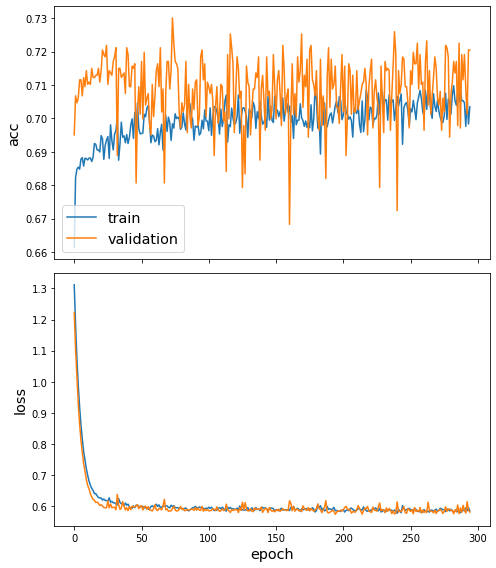

In [15]:
sg.utils.plot_history(history)

Finally, let us calculate the performance of the trained model on the test data.

In [16]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

  ['...']
112/112 [==============================] - 0s 3ms/step - loss: 0.5738 - acc: 0.7157

Test Set Metrics:
	loss: 0.5738
	acc: 0.7157


### Conclusion

We demonstrated the use of `StellarGraph`'s `DeepGraphConvolutionalNeuralNetwork` implementation for supervised graph classification algorithm. More specifically we showed how to  predict whether a chemical compound represented as a graph is an enzyme or not.

There is a small difference with regards to the performance on the same dataset published in [1]; the above training run achieves approximately $72\%$ accuracy whereas [1] reports $75.54\%\pm0.94$. This difference can be attributed to a small number of factors listed below, 
- We use a different training scheme, that is a single 90/10 split of the data as opposed to the 10-fold cross validation scheme used in [1]. We use a single fold for ease of exposition. 
- The experimental evaluation scheme in [1] does not specify some important details such as the regularisation used for the neural network layers; if a bias term is included; the weight initialization method used; and the batch size.

<table><tr><td>Run the master version of this notebook:</td><td><a href="https://mybinder.org/v2/gh/stellargraph/stellargraph/master?urlpath=lab/tree/demos/graph-classification/dgcnn-graph-classification.ipynb" alt="Open In Binder" target="_parent"><img src="https://mybinder.org/badge_logo.svg"/></a></td><td><a href="https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/graph-classification/dgcnn-graph-classification.ipynb" alt="Open In Colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg"/></a></td></tr></table>